# <p style="text-align: center;"> Interacting galaxies colours
    by Alban de Sainte Marie and Gabriele Berardi

Execution time : 15 to 30 minutes

# I. Index

I. Index

II. Abstract

III. Introduction

IV. Treatement of the Images

    1. Initialization
    
        a. Import modules
        b. Create a list of the path to the images
        c. Make the treatement of the images easier by creating a class image
        d. Sort the images
        e. Get rid of the unwanted images
        f. Separate our list into different lists of object
     
    2. Processing the frames
    
        a. The Master Bias
        b. The Master Dark
        c. The Masters Flat
        d. The actual images by filter
        e. Colourmaps and needed graphs
        
    3. Full artificial colour images
    
V. Analysis and Hypotheses

    1. 𝐻𝛼
    
        a. What is 𝐻𝛼?
        b. 𝐻𝛼 from M66, M65 and NGC3628
        c. Explanation
        d. Discussion
        
    2. Physical apparence
    
    3. Colour and Colour Scattering
    
        a. Colour
        b. Colour Scattering
        c. Discussion
    
VI. Evaluation

VII. Conclusion

VIII. Bibliographie

# II. Abstract

In this Notebook, we made a python algorithm to investigate the effect of the interaction of galaxies on their colours and stellar population. We observed the Leo Triplet with the Lauwersmeer Dark Sky Telescope to see the exact effect of those interactions. We saw that the galaxies were close to uniform in colour, with a concentration of $H_{\alpha}$ in the center and that they tended toward the blue. Our conclusion is that interacting galaxies have active star formation in their centre, which implies that the stellar population in interacting galaxies tend to have a larger number of new stars at the centre when compared to non-interacting ones.

# III. Introduction

Numerous studies have been done on the colour of interacting galaxies. The study of interacting galaxies is interesting because our own galaxy, the Milky Way, is interacting with a number of other galaxies, such as the Sagittarius dwarf galaxy or the Canis Major dwarf galaxy, and will probably merge with Andromeda. The colours of the galaxies are interesting to study because it brings a lot of informations on their compositions and activity.

The Leo Triplet, the galaxy system we chose to observe, is a set of three galaxies, M66, M55 and NGC 3628, or the Hamburger galaxy, situated about 10 731 KPc $^{(1)}$ away from us.

# IV. Treatement of the images

## 1. Initialization

### a. Import modules

In [ ]:
import numpy as np
import astroalign as aa

from pathlib import Path
from astropy.io import fits

from matplotlib.pyplot import subplots, show

from astropy.visualization import ImageNormalize, make_lupton_rgb
from astropy.visualization import SinhStretch, AsymmetricPercentileInterval, LinearStretch,\
                                  LogStretch, PowerStretch, SqrtStretch, SquaredStretch,\
                                  HistEqStretch

from astropy.nddata import fits_ccddata_reader
from ccdproc import Combiner

from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

### b. Create a list of the path to the images

In [ ]:
# from PROGNUM Task 8 (2)
# observation fits files directory
directory = Path("/net/virgo01/data/users/berardi/leoTriplets/2022-05-24")
# fits save directory
procdir = "/net/virgo01/data/users/berardi/leoTriplets/compile-2022-05-24/"
# local notebook directory to save more important images
ImgDir = os.getcwd()+"/Processed_Images/"
try:
    os.mkdir(ImgDir)
except:
    pass



path = Path(directory)
filepaths = []
for filepath in path.iterdir():
    if filepath.suffix.lower() in ['.fits', '.fit', '.fts']:
        filepaths.append(filepath)

### c. Make the treatement of the images easier by creating a class image

In [ ]:
# New class image with the necessary information to treat the image
class image:
    '''An image class which saves necessary meta data of the fits file located at filepath for processing'''
    def __init__(self, filepath, fits_imagetyp='', fits_exptime=0, fits_filter='', fits_time_obs=0,
                 fits_naxis1=0, fits_naxis2=0):
        self.filepath = filepath
        self.filename = filepath.name
        self.imagetyp = fits_imagetyp
        self.exptime = fits_exptime
        self.filter = fits_filter
        self.time_obs = fits_time_obs
        self.naxis1 = fits_naxis1
        self.naxis2 = fits_naxis2


# Put each image into the new class image
myimages = []
for filepath in filepaths:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    try:
        hdr['FILTER']
    except KeyError:
        n = "None"
    else:
        n = hdr['FILTER']
    newimage = image(filepath, hdr['IMAGETYP'], hdr['EXPTIME'], n, hdr['DATE-OBS'],
                         hdr['NAXIS1'], hdr['NAXIS2'])
    myimages.append(newimage)
    hdulist.close()

### d. Sort the images

In [ ]:
# Sort the images by time of observation
def getTime(image):  # from PROGNUM Task 8 (2)
    """returns the time of observation"""
    return image.time_obs

myimages.sort(key=getTime)

### e. Get rid of the unwanted images

Some Bias were taken by error at the start of the night, so we need to delete them out of the list of images.

In [ ]:
# Remove the unwanted images
del myimages[1:16]
del myimages[2:8]
            
# Verify that we only got rid of what we wanted to get rid of
# s = "{:<3s} {:<36s} {:<15s}"
# s = s.format('idx', 'filename', 'image typ')
# print(s)
# i = 0
# for img in myimages:
#     s = f'{i:<3d} {img.filename:<36} {img.imagetyp:<15}'
#     print(s)
#     i += 1

### f. Separate our list into different list of object

To be able to treat our images, we need to separate the flats, darks and bias from the light frames, but also the different light frames between themselves, because we took pictures of different things that are all in the same list. 

First we need to take a look at all the images, and separated them between the different object taken.

In [ ]:
# Separate the images into the four types of frame
bias = []
flats = []
dark = []
for img in myimages:
    if img.imagetyp == 'BIAS':
        bias.append(img)
    if img.imagetyp == 'FLAT':
        flats.append(img)
    if img.filter == 'Dark':
        dark.append(img)

        
# # Separate the light frame into the different objects taken, as seen when displayed
# LEO_TRIPLET = myimages[43:73]
# Gal1 = myimages[73:88]
# Gal2 = myimages[88:103]
# Gal3 = myimages[103:118]

The last few images in that folder are not from our observation, so they are not needed.

## 2. Processing the frames

The bias, flat frames and dark frames are the same for all the objects, so we can prepare those first before adding them to the light frames.

In [ ]:
# First we create a function that display the image when called (from PROGNUM Task 8 (2))
def displayimage(data, percentlow, percenthigh, title='', scale='linear', cmap='gray', save=False):
    """
    Displays a pyplot image from matplotlib using the 2d data array with values between 
    perecentlow and precenthigh.
    The optional scale argument can take the following values;
    'linear', 'sinh', 'log', 'power', 'sqrt', 'squared', 'hist'
    """
    interval = AsymmetricPercentileInterval(percentlow, percenthigh)
    vmin, vmax = interval.get_limits(data)
    """Display an image with different parameters"""
    if scale == 'linear':
        stretch = LinearStretch(slope=0.5, intercept=0.5)
    if scale == 'sinh':
        stretch = SinhStretch()
    if scale == 'log':
        stretch = LogStretch()
    if scale == 'power':
        stretch = PowerStretch(1.5)
    if scale == 'sqrt':
        stretch = SqrtStretch()
    if scale == 'squared':
        stretch = SquaredStretch()
    if scale == 'hist':
        stretch = HistEqStretch(data)  # Needs argument data and data min, max for vmin, vmax
        vmin = data.min(); vmax = data.max()

    fig, ax = subplots()
    norm = ImageNormalize(image, vmin=vmin, vmax=vmax, stretch=stretch)
    imgObj = ax.imshow(data, interpolation='none', origin='lower', cmap=cmap, norm=norm)
    if title:
        ax.set_title(title)
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
        
    # colour bar
    divider = make_axes_locatable(ax)
    colbarframe = divider.append_axes("right", size="5%", pad=0.15)
    fig.colorbar(imgObj, cax=colbarframe)
    colbarframe.set_ylabel("intensity")
    
    show()
    
    if save == True:
        fig.savefig(ImgDir+title)
        
    return vmin, vmax

### a. The Master bias

In [ ]:
# Find the bias per pixel position (from PROGNUM Task 8 (2))
images = []
for img in bias:
    hdulist = fits.open(img.filepath)
    images.append(hdulist[0].data)
    hdulist.close()
    
datacube = np.stack(images)
masterbias = np.median(datacube, axis=0)
del images

In [ ]:
# Save the bias and display it

# Create a function to easily save images in fits (from PROGNUM, Task 8 (2))
def writetoFITS(folder, data, filename, header=None):
    """Function which writes a 2D NumPy array to a FITS file
    It writes the file in the given argument folder and the
    name is given by argument filename.
    One can add a header from another FITS file with argument header"""
    
    hdu = fits.PrimaryHDU(data, header)
    hdul = fits.HDUList([hdu])
    path = folder+filename
    hdul.writeto(path, overwrite=True)
    
# Save with a appropriate header and display
hdulist = fits.open(bias[0].filepath)
hdr = hdulist[0].header
hdulist.close()
    
inconsistantHdrItems = ['DATE-OBS', 'EXPTIME', 'EXPOSURE','JD','JD-HELIO','AIRMASS','OBJCTALT','OBJCTAZ','OBJCTHA']
for item in inconsistantHdrItems:
    del hdr[item]
    
writetoFITS(procdir, masterbias, "masterBias.fits", header=hdr)
displayimage(masterbias, 5, 95,title="final processed bias image", scale='power')

### b. The Master dark

In [ ]:
# find the dark per pixel (from PROGNUM Task 8 (2))
images = []
for im in dark:
    hdulist = fits.open(im.filepath)
    images.append((hdulist[0].data - masterbias)/im.exptime)
    hdulist.close()

datacube = np.stack(images)
del images

# Make a Master dark
masterdark = np.median(datacube, axis=0)

In [ ]:
# Save the master dark and display it
    # Save with an appropriate header
    
hdulist = fits.open(dark[0].filepath)
hdr = hdulist[0].header
hdulist.close()

inconsistantHdrItems = ['DATE-OBS', 'EXPTIME', 'EXPOSURE','JD','JD-HELIO','AIRMASS','OBJCTALT','OBJCTAZ','OBJCTHA']
for item in inconsistantHdrItems:
    del hdr[item]


writetoFITS(procdir, masterdark, "masterDark.fits", header=hdr)

displayimage(masterdark, 5, 95, title='master dark frame', scale='squared')

### c. The Master Flats

In [ ]:
# We have a Master Flat for each filter
# So we define a function that creates it (from PROGNUM, Task 8 (2))
def getMasterFlat(flats, filtertype):
    """
    returns the master flat frame for the filter 'filtertype' in flats
    """
    images = []
    for img in flats:
        if img.filter == filtertype:
            hdulist = fits.open(img.filepath)
            data = hdulist[0].data.astype(float)
            data -= masterdark*img.exptime + masterbias
            data /= data.mean()
            
            images.append(data)
            hdulist.close()

    datacube = np.stack(images)
    masterflat = np.median(datacube, axis=0)
    masterflat /= masterflat.mean()
    
    return masterflat

In [ ]:
# get the master flat frame for each filter
filters = ["R*","G*","B*","H_alpha","Lum"]
masterflats = {f:getMasterFlat(flats, f) for f in filters}

# Save with an appropriate header and display each master flat
for f in filters:
    print(f"Standard deviation master Flat in {f}: {masterflats[f].std()}")
    
    for flat in flats: # finds an appropiate header to edit and save
        hdulist = fits.open(flat.filepath)
        hdr = hdulist[0].header
        if hdr['FILTER'] == f:
            inconsistantHdrItems = ['DATE-OBS', 'EXPTIME', 'EXPOSURE','JD','JD-HELIO','AIRMASS','OBJCTALT','OBJCTAZ','OBJCTHA']
            for item in inconsistantHdrItems:
                del hdr[item]
            
            break
        hdulist.close()
    
    writetoFITS(procdir, masterflats[f], f"masterFlat_{f}.fits", header=hdr)
    displayimage(masterflats[f], 5, 99, f"master flat frame in the {f} filter")
    

### d. The actual images by filters

To observe galaxy colours, we do not need an image with all the filters together, so for each galaxy, we are going to take the images per filter, and later make them into colourmaps.

In [ ]:
def process(galname, images, filters):
    """
    proccess the frames 'images' in the 'filters' bands
    returns a list of the combined images (one for every filter in 'filters')
    each image callibrated to get the proccesed light frame 
    then it is alligined, using the astropy routine, to a defualt image (images[0])
    and combined with other images (in the same filter)
    """
    lightImgs = []
    for img in images:
        hdulist = fits.open(img.filepath)
        data = hdulist[0].data.astype(float)
        hdr = hdulist[0].header

        # Substract the Master bias and the Master dark * exposure time of the light frame
        data -= masterbias + masterdark*img.exptime
        
        # Divide each image by the matching filter master flat
        data /= masterflats[img.filter]

        writetoFITS(procdir, data, "processed_"+str(img.filepath.name),header=hdr)
        lightImgs.append("processed_"+str(img.filepath.name))
        
        hdulist.close()
        
        
    # Align the obtained frames (from PROGNUM Task 8 (2))

    hdulist = fits.open(procdir+"/"+lightImgs[0])
    target_im = hdulist[0].data
    target_im = target_im.byteswap().newbyteorder("<")
    hdulist.close()

    alignedCubes = {f:[] for f in filters}

    for imgName in lightImgs:
        hdulist = fits.open(procdir+"/"+imgName)
        tobealigned_im = hdulist[0].data
        hdr = hdulist[0].header
        hdulist.close()

        # astroalign routine
        tobealigned_im = tobealigned_im.byteswap().newbyteorder("<")  # assign bytes in little endian encoding
        aligned_im, footprint = aa.register(tobealigned_im, target_im, 
                                            detection_sigma=3.0, min_area=15, max_control_points=100)
                                            # values here where chosen to make routine spend more time finding
                                            # matching triangles, whilst avoiding noise for better allignemt
                                            # with dithered(shifted) frames
        newname = imgName.replace("processed", "aligned")
        
        writetoFITS(procdir, aligned_im, newname, header=hdr)
        alignedCubes[hdr["FILTER"]].append(newname)


    
    
    # Put the images together for each filters using ccdproc combiner
    combinedImages = {}
    for filterType in filters:
        ccdDataList = []
        image0 = procdir+"/"+alignedCubes[filterType][0]
        hdulist = fits.open(image0)
        hdr0 = hdulist[0].header

        for imgName in alignedCubes[filterType]:
            ccdData = fits_ccddata_reader(procdir+"/"+imgName, unit="count")
            ccdDataList.append(ccdData)

        combiner = Combiner(ccdDataList)
        combinedFilterData = combiner.average_combine()
        filterName = f"Combined_{galname}_{filterType}_band_.fits"

        inconsistantHdrItems = ['DATE-OBS', 'EXPTIME', 'EXPOSURE','JD','JD-HELIO','AIRMASS','OBJCTALT','OBJCTAZ','OBJCTHA']
        for item in inconsistantHdrItems:
            del hdr0[item]
            
        
        writetoFITS(procdir, combinedFilterData, filterName, header=hdr0)
        combinedImages[filterType] = filterName
        
        
        # Display the obtained images with some colour
        displayimage(combinedFilterData, 5, 99, title = f"combined_image_in_the_{filterType}_filter", scale = "squared", cmap = 'magma', save=True)
        
        hdulist.close()
        
    return combinedImages

In [ ]:
processedAll = process("All", myimages[43:118], ["R*","G*","B*","H_alpha","Lum"])

### e. Colourmaps and needed graphs

The colourmaps will tell us about what colour is where, and thus the star population. We also make HR diagrams for each galaxy, with pixels instead of stars to see the luminosity per colour, and thus maybe the spectral type. And finally, we are making colour scattering diagrams to see the diversity of spectral types.

In [ ]:
# Create a function that make colourmaps for each colours and colours scattering diagrams
def colourMagnitude(galName, processedGal, area):
    """
    produces colourmaps of the processedGal data for each filter pair
    A H-R diagram is produced using a perpixel aproach using the B*-R* bands
    Using a similar approach for each filter pair a colour scattering diagram is displayed
    """
    
    # load the fits for each needed band
    hdulist = fits.open(procdir+"/"+processedGal["R*"])
    r = hdulist[0].data[area]
    hdulist = fits.open(procdir+"/"+processedGal["G*"])
    g = hdulist[0].data[area]
    hdulist = fits.open(procdir+"/"+processedGal["B*"])
    b = hdulist[0].data[area]
    hdulist = fits.open(procdir+"/"+processedGal["Lum"])
    lum = hdulist[0].data[area]
    hdulist.close()

    print(galName)

    # Colour differences for the colour map
    # we have to take the absolute value because some of our values are negative
    gb = -2.5*np.log(np.abs(g/b))
    br = -2.5*np.log(np.abs(b/r))
    gr = -2.5*np.log(np.abs(g/r))
    
    print(np.median(gb), np.median(br), np.median(gr))

    # HR diagram of B*-G* colour band versus the luminosity
    fig, ax= subplots()
    ax.set_facecolor((0,0,0))
    ax.scatter(gb, lum, s=0.5)
    ax.set_xlabel("B-G colour")
    ax.set_ylabel("luminosity (count)")
    ax.set_title(galName+"_HR_diagram")

    # Colourmaps of B*-G*, B*-R* and B*-R* bands
    displayimage(gb, 5,96, galName+"_g-b_colourmap", "squared", "viridis", save=True)
    displayimage(br, 5,96, galName+"_b-r_colourmap", "squared", "plasma", save=True)
    displayimage(gr, 5,96, galName+"_g-r_colourmap", "squared", "cividis", save=True)
    
    
    # Diagrams of colour scattering
    def colourdiag(data, colour1, colour2, colour1t="",colour2t=""):
        """produces a scatter diagram of colour1 and colour2 using each pixel as a point"""
        fig, ax = subplots()
        ax.set_facecolor((0,0,0))
        ax.scatter(colour1, colour2, s=0.5)
        
        ax.set_xlabel(colour1t)
        ax.set_ylabel(colour2t)
        
        ax.set_ylim(-2,2)
        ax.set_xlim(-2,2)
        title = ax.set_title(f"{galName}_{colour1t}-{colour2t}_colour_scattering_diagram")
        show()
        
        fig.savefig(ImgDir+title.get_text())

    colourdiag(processedGal, gb, br, "gb", "br")
    colourdiag(processedGal, br, gr, "br", "gr")
    colourdiag(processedGal, gb, gr, "gb", "gr")
    
        
    print("===================================================================================")

# Call the function
colourMagnitude("M66", processedAll, (slice(250,750), slice(2350,2650)))
colourMagnitude("M65", processedAll, (slice(550,1200), slice(800,1200)))
colourMagnitude("Ham", processedAll, (slice(3000,3500), slice(1800,2900)))

## 3. Full artificial colour images

Even if we do not need them for the analysis of the colours, we are making full colours images because we do have beautiful pictures, and they might be useful to see the impact of the interaction on the form of the galaxies.

In [ ]:
def displayRGBImage(name, combinedImages, area=None):
    """
    produces an RGB pyplot image through the make_lupton_rgb routine using the R*, G* and B* bands
    area takes in a slice tuple to select a patch of the image
    the optional argument save will save a full scale image (if true)
    """
    if (area == None):
        area = (slice(0,-1),slice(0,-1))
    Rmed = combinedImages["R*"]
    Gmed = combinedImages["G*"]
    Bmed = combinedImages["B*"]
    # Hmed = combinedImages["H_alpha"]
    # Lmed = combinedImages["Lum"]

    # These images were not flipped in Y yet
    hdulist = fits.open(procdir+"/" + Rmed)
    RImg = np.flip(np.rot90(hdulist[0].data[area]))

    hdulist = fits.open(procdir+"/" + Gmed)
    GImg = np.flip(np.rot90(hdulist[0].data[area]))

    hdulist = fits.open(procdir+"/" + Bmed)
    BImg = np.flip(np.rot90(hdulist[0].data[area]))
    hdulist.close()

    RImg /= RImg.mean()
    GImg /= GImg.mean()
    BImg /= BImg.mean()


    minimum = 0.95
    stretch = .5
    Q = 2 # values found through iteration to optimize readability and least background noise
    imageRVB = make_lupton_rgb(RImg, GImg, BImg,
                        minimum=minimum, stretch=stretch, Q=Q, filename=ImgDir+"/"+f"final_coloured_{name}.png")
    figure, axis = subplots()
    figure.set_size_inches(10, 8)
    axis.set_title(f"{name} full RGB coloured image")
    axis.set_xlabel('pixels')
    axis.set_ylabel('pixels')
    axis.imshow(imageRVB, origin="lower")
    show()

In [ ]:
displayRGBImage("M65", processedAll, (slice(250,750), slice(2350,2650)))
displayRGBImage("M64", processedAll, (slice(550,1200), slice(800,1200)))
displayRGBImage("Ham", processedAll, (slice(3000,3500), slice(1800,2900)))
displayRGBImage("All", processedAll, (slice(0,-1), slice(600, 3100)))

In [ ]:
displayRGBImage("All", processedAll, (slice(0,-1), slice(600, 3100)))

In [ ]:
displayRGBImage("Ham", processedAll, (slice(3000,3500), slice(1800,2900)))

# V. Analysis and Hypotheses

Now that we have the data, we need to analyse it, and find explanations as to why it is that way.

## 1. $H_{\alpha}$

### a. What is $H_{\alpha}$?

$H_{\alpha}$ is the emission line produced when a excited Hydrogen atom goes from the third to the second state of excitement. It is the first visible Hydrogen emission line, and it is particularly visible. We saw that on our galaxies, there were large amount of concentration of $H_{\alpha}$ in different patterns.

### b. 𝐻𝛼 from M66, M65 and NGC 3628

The images from this section were not made with code, but by merging manually two images, by adjusting their transparency and their contrast.

|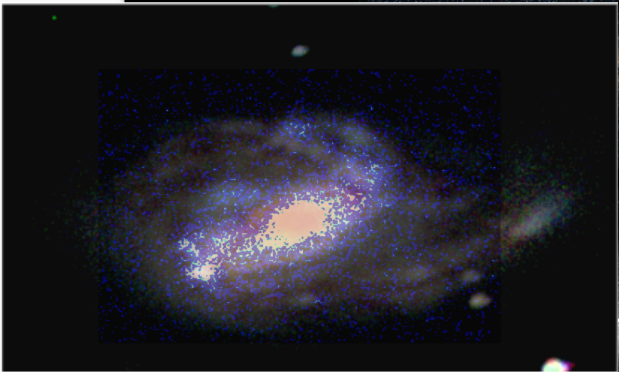|M66|
|-|-|

We can see that from M66, we receive a large amount of $H_{\alpha}$ from the center and a bit from a bar through the center.

|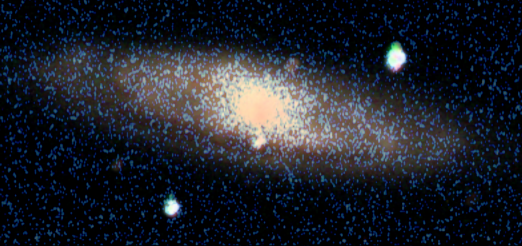|M65|
|-|-|

From M65, we receive a large amount of $H_{\alpha}$ only from a bulge in the center.

|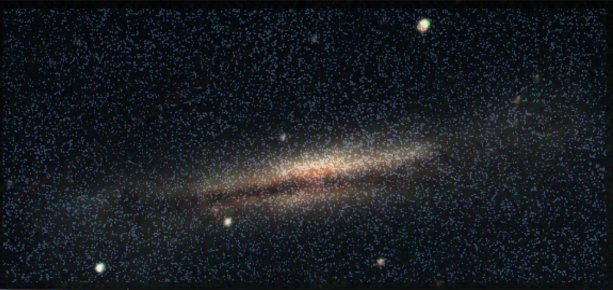|NGC 3628|
|-|-|

And from NGC 3628, we probably receive $H_{\alpha}$ from about the same places as from M65, even if the bulge is slightly smudged, but it is largely hidden by the dust belt.

|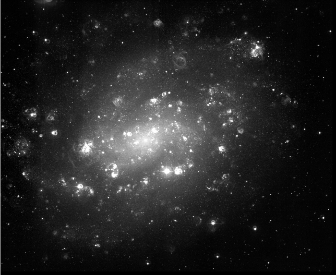|NGC 300, image free of right from ESO $^{(3)}$|
|-|-|

That amount of H_alpha in the center of the galaxies seems to be particular to interacting galaxies$^{(4)}$, while the concentration in isolated galaxies is spread out, as we can see on NGC 300.
That said, the bar of $H_{\alpha}$ on M66 might be due to the interaction too. Our hypothesis is that first the interaction formed a distinct bulge of $H_{\alpha}$ in the center, but that the gravity pull so clearly visible on the galaxy deformed that formed bulge. It might also be due to the fact that M66 is a barred galaxy, and $H_{\alpha}$ is spread out on the whole bulge, and not just the spherical center of it.

### c. Explanation

An explanation might be that the center of those galaxies are active and produce new stars.

Indeed, when galaxies produce new stars, they produce both small stars and massive ones. Some of those massive stars burn bright and short, which means that there presence indicate the recent formation of new stars. By burning so fast, they produce high energy radiations, like ultraviolet light. This ionize the hydrogen gas present in some galaxies, and when the electrons freed by the ionisation bind themselves to other atoms, it produces $H_{\alpha}$ emission lines. So the presence of $H_{\alpha}$ is an indicator of new stars formation.

Since there is a higher concentration of $H_{\alpha}$ in the center of interacting galaxies than in the center of isolated galaxy, we wondered why interacting galaxies produced more stars in their center.

The velocity of the gas dispersion is higher in interacting systems than in isolated galaxies $^{(5)}$. Often, the heavier atoms and molecules congregate in the center, in a few kiloparsecs. The gas distribution also becomes asymmetric, as we can see on our images, and it results in a twisting of the gas, which is pulled onward toward the center kiloparsecs. This large amount of congregating gas is the base stone for the formation of stars.

Interacting galaxies also produce more stars than non interacting galaxies, as they emit more toward the infrared, or 

### d. Discussion

Small and massive stars do not form at the same rate in every galaxies, so a high or low amount of $H_{\alpha}$ is not always an indicator of new stars formation, but it does often show that the galaxy is active.

## 2. Physical apparence

|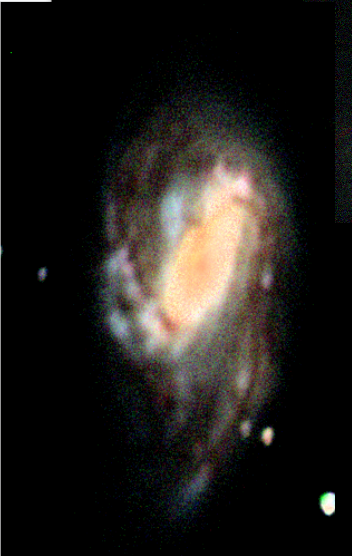|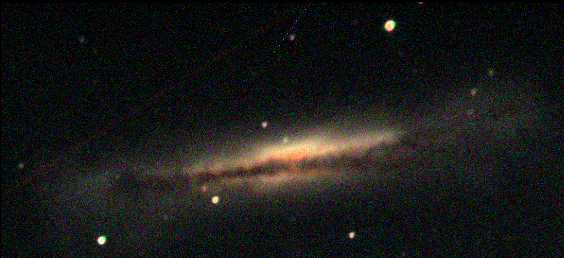|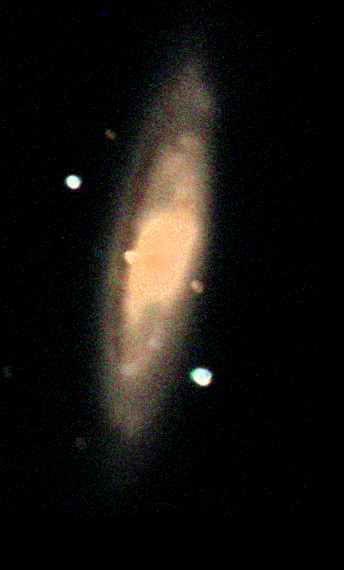|
|-|-|-|

There are two main features of a spiral galaxy, the central bulge, which contains the majority of the galaxy mass and the spiral arms. 

With Newton's law of gravitation, $F=\frac{GMm}{r^2}$, and Newton's second law, $F = ma$, we can see that the heavier parts of the galaxy and those closer to the other galaxies should have a higher acceleration, since the force is bigger. This means over time stars further away from the other galaxies and not part of the bulge will lag behind increasing the space between stars in the galaxy. Consequently it will appear to us as stretched. 

This is what we observe with M66 in our images, the lower arm is visibly longer than the higher arm. Looking at the centre we do not observe such similarities, this could just be due to the resolution of our images or since the bulge contains a large portion of the galaxies mass the interaction isn't strong enough to significantly change the path of individual stars.

Closely Observing NGC 3628, a slight concaval contour, towards the other two galaxies, can be seen. This is due to the stars and dust close to the edges of the galaxy that are less attracted to the central bulge and thus accelerate faster towards M66 and M65, causing this apperance of frayed edges. Additionally, while it is not visible on our images, there is a tidal tail extending from NGC 3628 toward the left, away from M66. A tidal tail is a tail of dust and stars caused by the gravitational pull of another object. We think that that tidal tail was caused by a fourth galaxy “flying by” and pulling some of NGC 3628 matter with it.

By its appearence, it would seems that M65 is the galaxy the less affected by the interaction. But as we saw before with the presence of $H_{\alpha}$ and will see later with the colours of the different galaxies, M65 is probably interacting with the two others just as much as M66 and NGC 3628 together. It is likely that any physical deformations are hidden by its inclination.

## 3. Colour and Colour Scattering

### a. Colour

|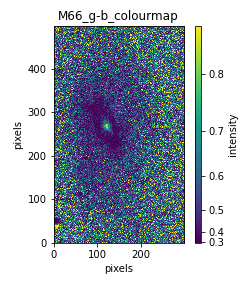|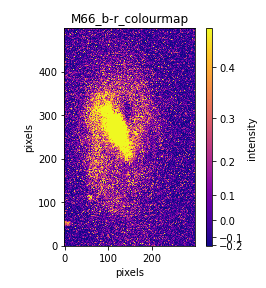|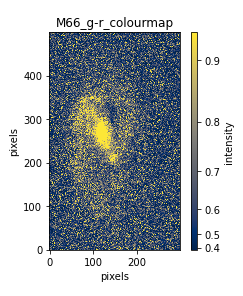|
|-|-|-|

The center of M66 tends toward the green, and the arms toward the blue. It shine blue far brighter than red everywhere. And shine green brighter than red also. Thus, the galaxy tends toward the blue overall.

|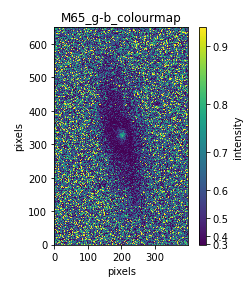|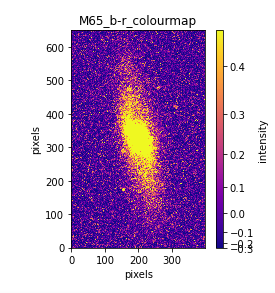|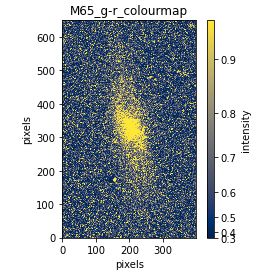|
|-|-|-|

In M65 too, we can see that the center tends toward the green, and the arms toward the blue, and that both the blue and the green are brighter than the red. It also tends toward the blue overall.

|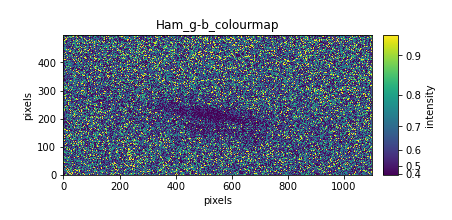|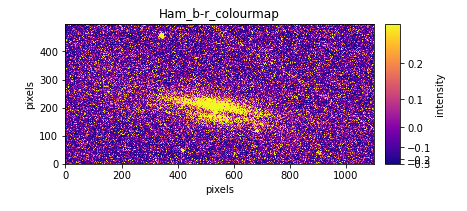|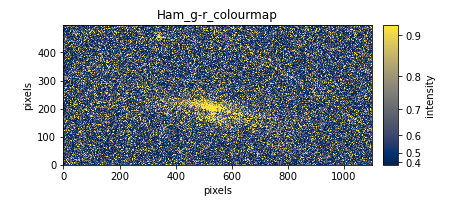|
|-|-|-|

And finally in NGC 3628, the green center is invisible, probably due to the dust belt. Both blue and green are brighter than red, and as blue is brighter than green, this galaxy also tend toward the blue.

From the intensity of the different colours, we can see that those three galaxies have approximately the same brightness in all colours, so they are mostly uniform in colours.

Those three galaxies shine blue, which correlate the earlier hypothesis that they are galaxies forming new stars.

The slightly lower intensity in NGC 3628 might be due to the dust belt.

### b. Colour Scattering

Each point on the graphs is a pixel from our pictures, for M66, M65 and NGC 3628 in this order, for each column.
They shows the colour scattering between B-R, G-B and G-R of our 3 galaxies.

|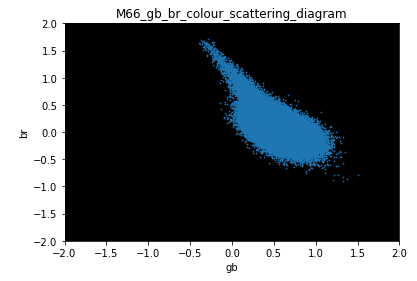|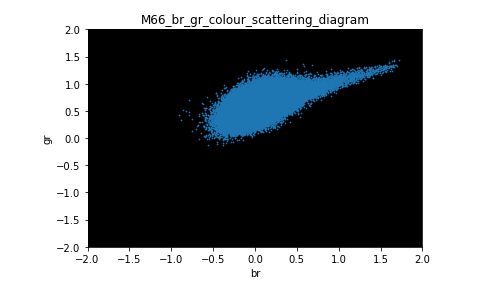|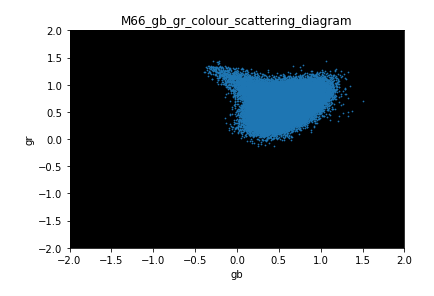|
|-|-|-|

|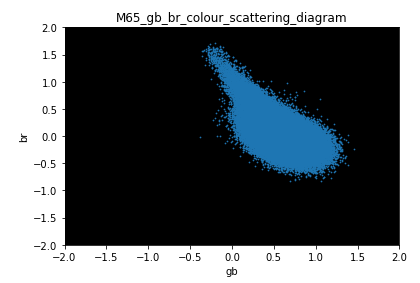|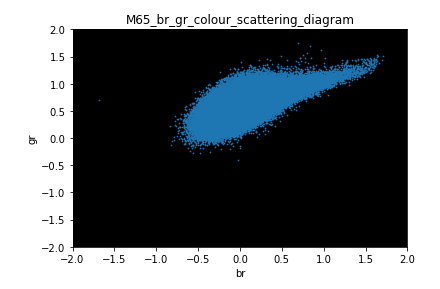|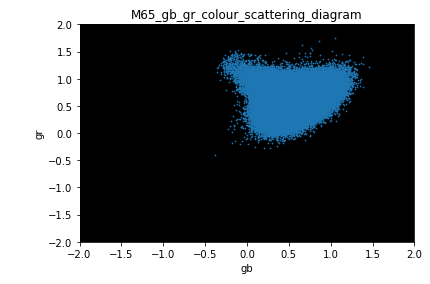|
|-|-|-|

|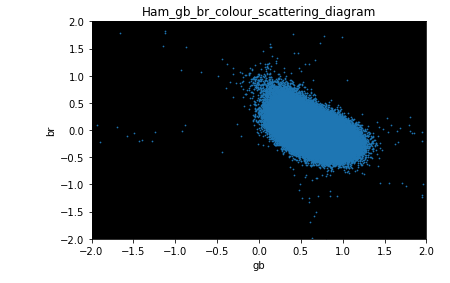|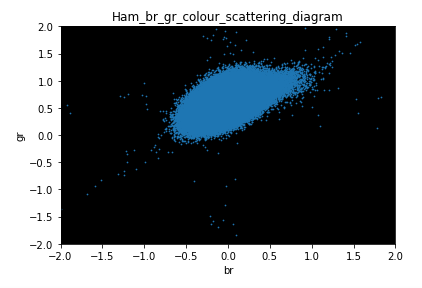|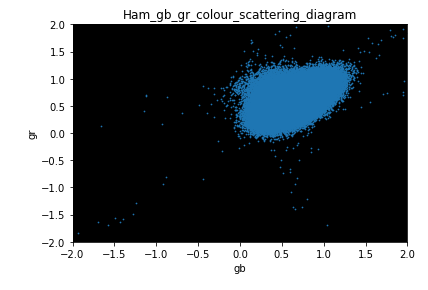|
|-|-|-|

We can see that the scattering of colours is nearly identical in all three galaxies. This is called the Holmberg effect $^{(6)}$. It shows once again that the galaxies are mostly uniform in colour.

As colour scattering in the diagrams form near dots, while the tail is probably due to the background, we can see that the colours of the stars in the galaxies are also very uniform. We do not know if this uniformity is linked to the interaction or if it is common to all galaxies.


We were not able to find an explanation as to why the colours of the galaxy is affected by the interaction, but it does mean that the diversity of the stellar population of the galaxies is affected, as the colours are mostly determined by the type of the stars. It seems that in interacting galaxies, the stellar population is nearly identical in the different members of the system.

### c. Discussion

Our vision of the colours of those galaxies might be made faulty by a number of things, like the atmosphere or interstellar reddening, but since they are all at about the same distance and the same position, their light would undergo the same changes, and the uniformity of it would stay the same. So while our conclusions on the colours of the different galaxies may be false, our conclusions on the scattering of those colour should be sound.

# VI. Evaluation

We can see on the side of the full colour image of all three galaxies that the telescope distorded the image. The fact that we also took images centered on the different galaxies partially countered that effect.

Our long exposures allowed us to identify a quasar, using simbad, with an apparent magnitude of 18.08 in the B filter at the centre of the image. Toward the outer edges the dimmest apparent magnitude identified of a galaxy was about 15.3, this differences is probably due to the aberrations noticed.

As we have no images of an isolated galaxy, we were not able to make some conlusions on the difference between the colours of an interacting or isolated galaxy.

# VII. Conclusion

The colours of the galaxies are clearly affected by their interaction. By observing these colours we were able to make 
a definite conclusion that the three galaxies are interacting with each other and that it affect their stellar population, with newer stars being produced at the center. This is an interesting conclusion as we can make predictions of the stellar population of our own galaxy, since it is strongly interacting with Andromeda. If the uniformity we saw applies to all interacting galaxies, the diversity of the stellar population in our galaxy should be close to the diversity in Andromeda.

# VIII. Bibliographie

$^{(1)}$
Triplet du Lion - Wikipedia - https://fr.wikipedia.org/wiki/Triplet_du_Lion

$^{(2)}$
Introduction to Programming and Computational Methods, Task 8, Dr. M.G.R. Vogelaar, 2022

$^{(3)}$
Spiral galaxy NGC 300 (H-alpha band) - ESO - https://www.eso.org/public/images/eso0221c/

$^{(4)}$
Galaxy interactions and star formation: Results of a survey of global H-alpha emission in spiral galaxies in 8 clusters - Quote - C.Moss - 1990 - https://ntrs.nasa.gov/citations/19910007592

$^{(5)}$
Star formation in galaxy interactions and mergers - Frederic Bournaud, CEA Saclay - 2010 - https://ned.ipac.caltech.edu/level5/March11/Bournaud/Bournaud_contents.html

$^{(6)}$
colour correlation between paired galaxies : the Holmberg effect - VV Demin, AV Zasov, EA Dibai, AN Tomov - 1984- https://adsabs.harvard.edu/pdf/1984SvA....28..367D